In [24]:
from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image

In [25]:
# Variables
# Paramètres de connexion MySQL
db_url = "jdbc:mysql://localhost:3306/wildlens?serverTimezone=UTC"
db_properties = { "user": "root",
                  "password": "root",
                  "driver": "com.mysql.cj.jdbc.Driver" }
mysql_driver_path = os.path.abspath("mysql-connector-j-9.1.0.jar")

In [26]:
# Initialisation de SparkSession
spark = SparkSession.builder \
    .appName("WildLens ETL - MSPR 24-25") \
    .config("spark.jars", mysql_driver_path) \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.memory.offHeap.enabled", "true") \
    .config("spark.memory.offHeap.size", "2g") \
    .getOrCreate()

print("✅ Spark initialisé avec le driver MySQL :", mysql_driver_path)
print(spark.sparkContext.getConf().get("spark.jars"))


✅ Spark initialisé avec le driver MySQL : /home/cedric/PycharmProjects/MSPR_ETL/ETL/mysql-connector-j-9.1.0.jar
/home/cedric/PycharmProjects/MSPR_ETL/ETL/mysql-connector-j-9.1.0.jar


In [27]:
try:
    # 📌 Tentative de lecture des tables MySQL
    df_tables = spark.read.jdbc(url=db_url, table="information_schema.tables", properties=db_properties)

    # 📌 Affichage des tables disponibles dans la base `wildlens`
    df_tables.filter(df_tables["TABLE_SCHEMA"] == "wildlens").select("TABLE_NAME").show()

    print("✅ Connexion à MySQL réussie et tables listées avec succès !")

except Exception as e:
    print(f"❌ Erreur de connexion à MySQL : {e}")

+-------------------+
|         TABLE_NAME|
+-------------------+
|      ImagesAnimaux|
| wildlens_d1_images|
|   wildlens_d2_zone|
|wildlens_d3_especes|
|     wildlens_facts|
+-------------------+

✅ Connexion à MySQL réussie et tables listées avec succès !


# Gestion des métadonnées des espèces

 Dans un premier temps, nous scannons les dossiers disponibles afin d'en faire un dataframe et réutiliser ces informations.
 Puis nous récupérons les métadonnées depuis l'API Mistral grâce à un prompt optimisé (optimisation du grounding, du prompt engineering)
 un sleep de 3s a été ajouté afin d'éviter de trop spam l'API
 -- transféré dans un fichier à part --

In [28]:
folder_all_animals = [d for d in os.listdir("data/OpenAnimalTracks/raw_imgs") if os.path.isdir(os.path.join("data/OpenAnimalTracks/raw_imgs", d))]
df_all_animals = pd.DataFrame(folder_all_animals, columns=["Nom du dossier"])

# Gestion des images
Dans un premier temps, nous allons faire une première analyse des images: leurs nombre par espèces (donc, par dossier), leurs tailles moyenne, leurs poid moyen, etc...

blackbear/342728199_915968203037512_5266104542370883226_n.jpg
blackbear/349342262_759177655751223_2450615800933432587_n.jpg
blackbear/500540.jpg
blackbear/10081196.jpg
blackbear/500586.jpg
blackbear/347032155_9142829699125317_4480660196649342397_n.jpg
blackbear/95606156.jpg
blackbear/236392060.jpg
blackbear/10081186.jpg
blackbear/2361704.jpg
blackbear/10081242.jpg
blackbear/track_rear-front_left_800x600-600x450.jpg
blackbear/64381581.jpg
blackbear/188381148.jpg
blackbear/96380015.jpg
blackbear/172720382.jpg
blackbear/350448755_1903873699980737_7803160368041616925_n.jpg
blackbear/262138375.jpg
blackbear/96380909.jpg
blackbear/104989419.jpg
blackbear/107534556.jpg
blackbear/95769076.jpg
blackbear/10081223.jpg
blackbear/83700303.jpg
blackbear/96381180.jpg
blackbear/tracks_mud_800x600.jpg
blackbear/5967951.jpg
blackbear/75804389.jpg
blackbear/75804673.jpg
blackbear/96381130.jpg
blackbear/96378704.jpg
blackbear/1075954.jpg
blackbear/95607097.jpg
blackbear/10081190.jpg
blackbear/Black-Bear-T

,Nom du dossier,Nombre d'images_raw,Largeur Moyenne_raw,Hauteur Moyenne_raw,Nombre d'images_val,Largeur Moyenne_val,Hauteur Moyenne_val,Nombre d'images_train,Largeur Moyenne_train,Hauteur Moyenne_train,Nombre d'images_test,Largeur Moyenne_test,Hauteur Moyenne_test
0,blackbear,236,981.076271,853.016949,27,414.148148,374.370370,186,447.930108,421.924731,0,NaN,NaN
1,mouse,88,768.750000,622.295455,24,109.166667,132.000000,129,152.310078,159.891473,38,125.447368,136.552632
2,horse,56,1273.446429,1089.767857,12,176.250000,153.916667,71,383.521127,340.492958,14,413.357143,373.642857
3,gray_fox,134,1073.880597,819.679104,15,370.666667,353.133333,126,278.182540,283.531746,39,257.974359,255.974359
4,coyote,132,961.363636,958.477273,17,351.058824,340.823529,123,359.276423,405.422764,32,427.531250,466.531250
5,skunk,132,1098.969697,999.159091,14,481.071429,597.785714,122,442.180328,504.950820,40,382.725000,474.325000
6,american_mink,131,1147.305344,877.351145,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN
7,mountainlion,106,901.198113,819.292453,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN
8,canada_goose,120,982.333333,749.841667,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN
9,rat,91,1140.615385,797.560440,21,168.571429,157.904762,116,208.051724,204.767241,36,195.305556,192.777778


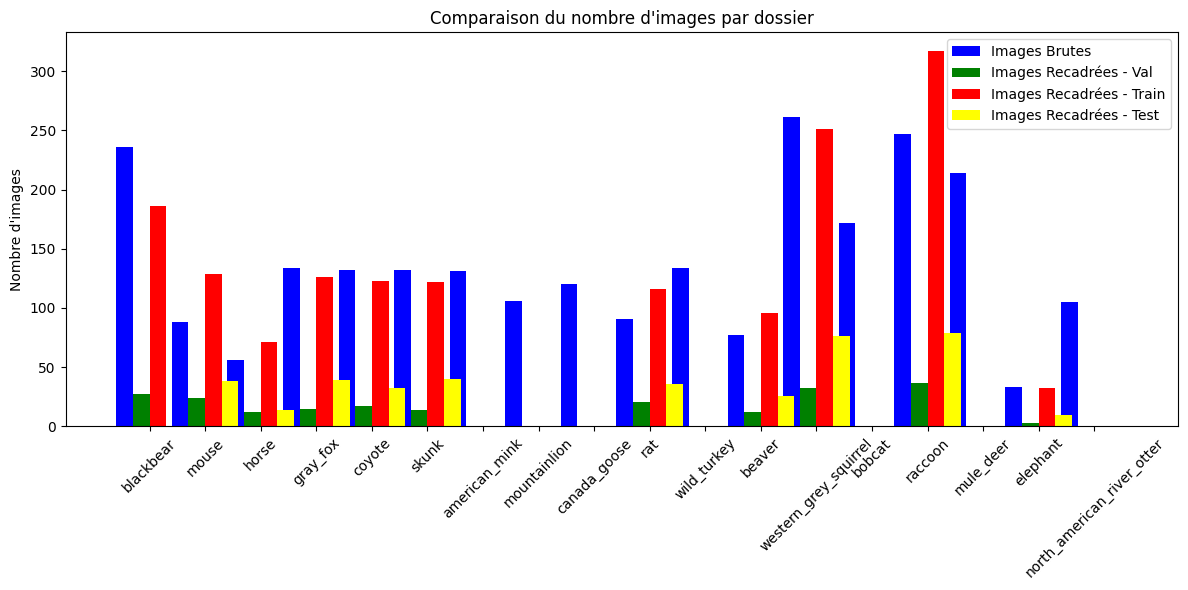

In [29]:
# Définition des chemins des datasets
raw_imgs = "data/OpenAnimalTracks/raw_imgs"
cropped_imgs_val = "data/OpenAnimalTracks/cropped_imgs/val"
cropped_imgs_train = "data/OpenAnimalTracks/cropped_imgs/train"
cropped_imgs_test = "data/OpenAnimalTracks/cropped_imgs/test"

# Fonction pour récupérer les infos des images d'un dossier (en gérant les dossiers absents)
def get_image_info(folder_path):
    if not os.path.exists(folder_path):  # 📌 Vérifie si le dossier existe
        return 0, None, None  # ⚠️ Si absent → 0 images et tailles nulles

    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('png', 'jpg', 'jpeg'))]
    num_images = len(image_files)

    if num_images == 0:
        return num_images, None, None  # Aucun fichier image

    widths, heights = [], []

    for img_file in image_files:
        img_path = os.path.join(folder_path, img_file)

        relative_path = os.path.join(os.path.basename(folder_path), img_file)
        print(relative_path)

        try:
            with Image.open(img_path) as img:
                widths.append(img.width)
                heights.append(img.height)
        except Exception as e:
            print(f"Erreur avec l'image {img_file}: {e}")

    avg_width = sum(widths) / len(widths) if widths else None
    avg_height = sum(heights) / len(heights) if heights else None

    return num_images, avg_width, avg_height

# Listes pour stocker les infos
image_data_raw = []
image_data_cropped_val = []
image_data_cropped_train = []
image_data_cropped_test = []

# Parcourir chaque dossier et extraire les infos
for folder in df_all_animals["Nom du dossier"]:
    # 📂 Images brutes
    folder_path_raw = os.path.join(raw_imgs, folder)
    num_images_raw, avg_width_raw, avg_height_raw = get_image_info(folder_path_raw)
    image_data_raw.append([folder, num_images_raw, avg_width_raw, avg_height_raw])

    # ✂️ Images recadrées - validation
    folder_path_val = os.path.join(cropped_imgs_val, folder)
    num_images_val, avg_width_val, avg_height_val = get_image_info(folder_path_val)
    image_data_cropped_val.append([folder, num_images_val, avg_width_val, avg_height_val])

    # ✂️ Images recadrées - entraînement
    folder_path_train = os.path.join(cropped_imgs_train, folder)
    num_images_train, avg_width_train, avg_height_train = get_image_info(folder_path_train)
    image_data_cropped_train.append([folder, num_images_train, avg_width_train, avg_height_train])

    # ✂️ Images recadrées - entraînement
    folder_path_test = os.path.join(cropped_imgs_test, folder)
    num_images_test, avg_width_test, avg_height_test = get_image_info(folder_path_test)
    image_data_cropped_test.append([folder, num_images_test, avg_width_test, avg_height_test])

# Création des DataFrames
df_raw = pd.DataFrame(image_data_raw, columns=["Nom du dossier", "Nombre d'images", "Largeur Moyenne", "Hauteur Moyenne"])
df_val = pd.DataFrame(image_data_cropped_val, columns=["Nom du dossier", "Nombre d'images", "Largeur Moyenne", "Hauteur Moyenne"])
df_train = pd.DataFrame(image_data_cropped_train, columns=["Nom du dossier", "Nombre d'images", "Largeur Moyenne", "Hauteur Moyenne"])
df_test = pd.DataFrame(image_data_cropped_test, columns=["Nom du dossier", "Nombre d'images", "Largeur Moyenne", "Hauteur Moyenne"])

# Fusion des DataFrames pour comparaison
df_comparaison = df_raw.merge(df_val, on="Nom du dossier", suffixes=("_raw", "_val"))
df_comparaison = df_comparaison.merge(df_train, on="Nom du dossier", suffixes=("", "_train"))
df_comparaison = df_comparaison.merge(df_test, on="Nom du dossier", suffixes=("", "_test"))

# Renommer les colonnes pour plus de clarté
df_comparaison.rename(columns={
    "Nombre d'images": "Nombre d'images_train",
    "Largeur Moyenne": "Largeur Moyenne_train",
    "Hauteur Moyenne": "Hauteur Moyenne_train",
}, inplace=True)

# Affichage du DataFrame de comparaison
display(df_comparaison)

# 📊 Visualisation : Comparaison du nombre d'images par dossier
plt.figure(figsize=(12,6))

x_labels = df_comparaison["Nom du dossier"]
x_range = range(len(x_labels))

plt.bar(x_range, df_comparaison["Nombre d'images_raw"], width=0.3, label="Images Brutes", color='blue')
plt.bar([x + 0.3 for x in x_range], df_comparaison["Nombre d'images_val"], width=0.3, label="Images Recadrées - Val", color='green')
plt.bar([x + 0.6 for x in x_range], df_comparaison["Nombre d'images_train"], width=0.3, label="Images Recadrées - Train", color='red')
plt.bar([x + 0.9 for x in x_range], df_comparaison["Nombre d'images_test"], width=0.3, label="Images Recadrées - Test", color='yellow')

plt.xticks([x + 0.45 for x in x_range], x_labels, rotation=45)  # Centrage des labels
plt.ylabel("Nombre d'images")
plt.title("Comparaison du nombre d'images par dossier")
plt.legend()
plt.tight_layout()
plt.show()



,Nom du dossier,Largeur Moyenne,Hauteur Moyenne,Poids Moyen (Ko),Taille Moyenne (Pixels)
0,blackbear,981.076271,853.016949,859.886222,8.949164e+05
1,mouse,768.750000,622.295455,483.855513,5.327778e+05
2,horse,1273.446429,1089.767857,1532.209891,2.179041e+06
3,gray_fox,1073.880597,819.679104,984.256333,9.940493e+05
4,coyote,961.363636,958.477273,850.411547,1.117847e+06
5,skunk,1098.969697,999.159091,1275.430893,1.169852e+06
6,american_mink,1147.305344,877.351145,1189.882589,1.216812e+06
7,mountainlion,901.198113,819.292453,900.470611,8.145616e+05
8,canada_goose,982.333333,749.841667,871.443376,9.140300e+05
9,rat,1140.615385,797.560440,1081.035306,9.927807e+05


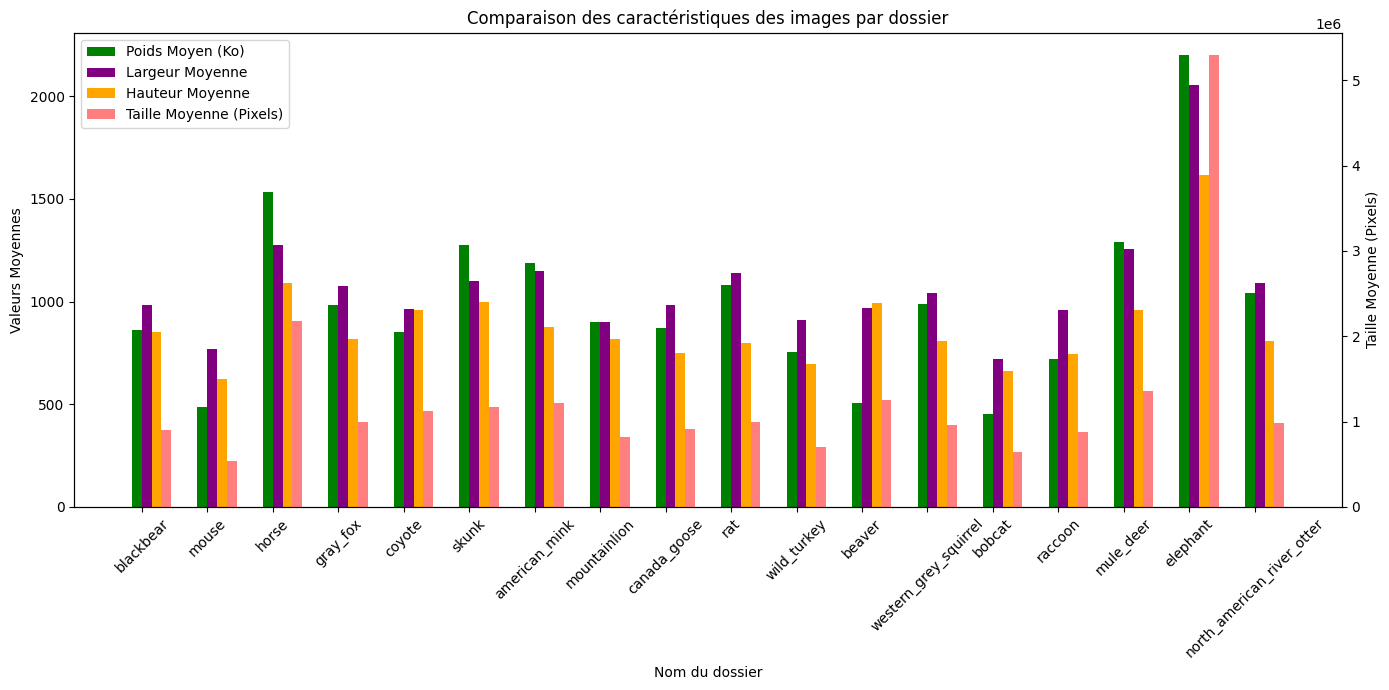

In [30]:
# 🔄 Fonction corrigée pour éviter le shadowing et enlever le "Nombre d'images"
def get_image_info_extended(folder_path):
    if not os.path.exists(folder_path):
        return None, None, 0, 0

    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('png', 'jpg', 'jpeg'))]

    widths_list, heights_list, sizes_kb_list, total_pixels_list = [], [], [], []

    for img_file in image_files:
        img_path = os.path.join(folder_path, img_file)
        try:
            with Image.open(img_path) as img:
                img_width, img_height = img.size
                file_size_kb = os.path.getsize(img_path) / 1024
                widths_list.append(img_width)
                heights_list.append(img_height)
                sizes_kb_list.append(file_size_kb)
                total_pixels_list.append(img_width * img_height)
        except Exception as e:
            print(f"Erreur avec l'image {img_file}: {e}")

    avg_img_width = sum(widths_list) / len(widths_list) if widths_list else None
    avg_img_height = sum(heights_list) / len(heights_list) if heights_list else None
    avg_size_kb = sum(sizes_kb_list) / len(sizes_kb_list) if sizes_kb_list else None
    avg_total_pixels = sum(total_pixels_list) / len(total_pixels_list) if total_pixels_list else None

    return avg_img_width, avg_img_height, avg_size_kb, avg_total_pixels

# 📊 Stockage des données étendues sans "Nombre d'images"
image_data_extended = []

for folder in df_all_animals["Nom du dossier"]:
    folder_path_raw = os.path.join(raw_imgs, folder)
    avg_img_width, avg_img_height, avg_size_kb, avg_total_pixels = get_image_info_extended(folder_path_raw)
    image_data_extended.append([folder, avg_img_width, avg_img_height, avg_size_kb, avg_total_pixels])

# 🔗 Création DataFrame mis à jour
df_extended = pd.DataFrame(image_data_extended, columns=["Nom du dossier", "Largeur Moyenne", "Hauteur Moyenne", "Poids Moyen (Ko)", "Taille Moyenne (Pixels)"])

# 👁️‍🗨️ Affichage du DataFrame
display(df_extended)

# 📊 Nouveau graphique avec axe secondaire (sans Nombre d'images)
fig, ax1 = plt.subplots(figsize=(14,7))

x_labels = df_extended["Nom du dossier"]
x_range = range(len(x_labels))

# 📏 Axe principal pour Poids et Dimensions
ax1.bar([x + 0.15 for x in x_range], df_extended["Poids Moyen (Ko)"], width=0.15, label="Poids Moyen (Ko)", color='green')
ax1.bar([x + 0.3 for x in x_range], df_extended["Largeur Moyenne"], width=0.15, label="Largeur Moyenne", color='purple')
ax1.bar([x + 0.45 for x in x_range], df_extended["Hauteur Moyenne"], width=0.15, label="Hauteur Moyenne", color='orange')

ax1.set_xlabel("Nom du dossier")
ax1.set_ylabel("Valeurs Moyennes")
ax1.set_xticks([x + 0.225 for x in x_range])
ax1.set_xticklabels(x_labels, rotation=45)

# 📊 Axe secondaire pour la Taille Moyenne (Pixels)
ax2 = ax1.twinx()
ax2.bar([x + 0.6 for x in x_range], df_extended["Taille Moyenne (Pixels)"], width=0.15, label="Taille Moyenne (Pixels)", color='red', alpha=0.5)
ax2.set_ylabel("Taille Moyenne (Pixels)")

# 🔖 Combinaison des légendes des deux axes
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper left')

plt.title("Comparaison des caractéristiques des images par dossier")
plt.tight_layout()
plt.show()


In [31]:
import os
import pandas as pd
from pyspark.sql.types import StructType, StructField, StringType, BinaryType
from PIL import Image
from tqdm import tqdm

# ➔ Fonction pour convertir une image en BLOB
def image_to_blob(image_path):
    with open(image_path, 'rb') as file:
        return file.read()

# ➔ Dossiers d'images
all_image_folders = [raw_imgs, cropped_imgs_val, cropped_imgs_train, cropped_imgs_test]

# ➔ Liste temporaire pour stocker les données par lot
image_data = []
batch_size = 50
current_batch = 0

# ➔ Schéma pour Spark DataFrame
schema = StructType([
    StructField("animal_name", StringType(), True),
    StructField("image_blob", BinaryType(), True)
])

# ➔ Étape 1 : Compter le nombre total d'images pour la barre globale
total_images = 0
for folder_path in all_image_folders:
    if os.path.exists(folder_path):
        for root, dirs, files in os.walk(folder_path):
            total_images += len([f for f in files if f.lower().endswith(('png', 'jpg', 'jpeg'))])

# ➔ Barre de progression globale
with tqdm(total=total_images, desc="🔄 Insertion des images dans MySQL", unit="image") as pbar:
    # ➔ Parcours des dossiers et traitement par lots
    for folder_path in all_image_folders:
        if os.path.exists(folder_path):
            for root, dirs, files in os.walk(folder_path):
                for image_file in files:
                    if image_file.lower().endswith(('png', 'jpg', 'jpeg')):
                        img_path = os.path.join(root, image_file)
                        animal_name = os.path.basename(os.path.dirname(img_path))
                        img_blob = image_to_blob(img_path)
                        image_data.append((animal_name, img_blob))

                        # ➔ Met à jour la barre de progression
                        pbar.update(1)

                        # ➔ Si le lot atteint le batch_size, envoi vers MySQL
                        if len(image_data) == batch_size:
                            current_batch += 1
                            df_batch = pd.DataFrame(image_data, columns=["animal_name", "image_blob"])
                            spark_batch_df = spark.createDataFrame(df_batch, schema=schema)

                            # ➔ Écriture du lot dans MySQL
                            spark_batch_df.write.format("jdbc") \
                                .option("url", db_url) \
                                .option("dbtable", "ImagesAnimaux") \
                                .option("user", db_properties["user"]) \
                                .option("password", db_properties["password"]) \
                                .option("driver", db_properties["driver"]) \
                                .option("batchsize", "100") \
                                .mode("append") \
                                .save()

                            print(f"✅ Lot {current_batch} inséré avec succès ({batch_size} images).")
                            image_data = []

    # ➔ Insertion des images restantes (< batch_size) si nécessaire
    if image_data:
        current_batch += 1
        df_batch = pd.DataFrame(image_data, columns=["animal_name", "image_blob"])
        spark_batch_df = spark.createDataFrame(df_batch, schema=schema)

        spark_batch_df.write.format("jdbc") \
            .option("url", db_url) \
            .option("dbtable", "ImagesAnimaux") \
            .option("user", db_properties["user"]) \
            .option("password", db_properties["password"]) \
            .option("driver", db_properties["driver"]) \
            .option("batchsize", "100") \
            .mode("append") \
            .save()

        print(f"✅ Dernier lot ({len(image_data)} images) inséré avec succès.")

# ➔ Arrêt de la session Spark
spark.stop()

print("✅ Toutes les données ont été insérées dans la base MySQL.")


🔄 Insertion des images dans MySQL:   1%|          | 51/6048 [00:01<02:17, 43.58image/s]

✅ Lot 1 inséré avec succès (50 images).


25/02/25 16:54:30 WARN TaskSetManager: Stage 2 contains a task of very large size (4600 KiB). The maximum recommended task size is 1000 KiB.
🔄 Insertion des images dans MySQL:   2%|▏         | 101/6048 [00:02<02:41, 36.85image/s]25/02/25 16:54:31 WARN TaskSetManager: Stage 3 contains a task of very large size (4313 KiB). The maximum recommended task size is 1000 KiB.


✅ Lot 2 inséré avec succès (50 images).


🔄 Insertion des images dans MySQL:   2%|▏         | 151/6048 [00:03<01:57, 50.11image/s]

✅ Lot 3 inséré avec succès (50 images).


25/02/25 16:54:32 WARN TaskSetManager: Stage 4 contains a task of very large size (2480 KiB). The maximum recommended task size is 1000 KiB.
🔄 Insertion des images dans MySQL:   3%|▎         | 201/6048 [00:04<01:46, 55.03image/s]

✅ Lot 4 inséré avec succès (50 images).


25/02/25 16:54:32 WARN TaskSetManager: Stage 5 contains a task of very large size (2182 KiB). The maximum recommended task size is 1000 KiB.
🔄 Insertion des images dans MySQL:   4%|▍         | 251/6048 [00:05<01:57, 49.30image/s]

✅ Lot 5 inséré avec succès (50 images).


25/02/25 16:54:34 WARN TaskSetManager: Stage 6 contains a task of very large size (2554 KiB). The maximum recommended task size is 1000 KiB.
🔄 Insertion des images dans MySQL:   5%|▍         | 301/6048 [00:05<01:32, 62.19image/s]

✅ Lot 6 inséré avec succès (50 images).


25/02/25 16:54:34 WARN TaskSetManager: Stage 7 contains a task of very large size (1147 KiB). The maximum recommended task size is 1000 KiB.
🔄 Insertion des images dans MySQL:   6%|▌         | 351/6048 [00:06<01:44, 54.52image/s]

✅ Lot 7 inséré avec succès (50 images).


25/02/25 16:54:35 WARN TaskSetManager: Stage 8 contains a task of very large size (26305 KiB). The maximum recommended task size is 1000 KiB.
🔄 Insertion des images dans MySQL:   7%|▋         | 401/6048 [00:08<02:11, 42.93image/s]25/02/25 16:54:37 WARN TaskSetManager: Stage 9 contains a task of very large size (1939 KiB). The maximum recommended task size is 1000 KiB.


✅ Lot 8 inséré avec succès (50 images).


🔄 Insertion des images dans MySQL:   7%|▋         | 451/6048 [00:09<02:17, 40.68image/s]

✅ Lot 9 inséré avec succès (50 images).


25/02/25 16:54:38 WARN TaskSetManager: Stage 10 contains a task of very large size (2249 KiB). The maximum recommended task size is 1000 KiB.
🔄 Insertion des images dans MySQL:   8%|▊         | 501/6048 [00:11<02:20, 39.43image/s]25/02/25 16:54:40 WARN TaskSetManager: Stage 11 contains a task of very large size (2304 KiB). The maximum recommended task size is 1000 KiB.


✅ Lot 10 inséré avec succès (50 images).


🔄 Insertion des images dans MySQL:   9%|▉         | 551/6048 [00:11<01:53, 48.38image/s]

✅ Lot 11 inséré avec succès (50 images).


25/02/25 16:54:40 WARN TaskSetManager: Stage 12 contains a task of very large size (5768 KiB). The maximum recommended task size is 1000 KiB.
🔄 Insertion des images dans MySQL:  10%|▉         | 601/6048 [00:13<02:13, 40.72image/s]25/02/25 16:54:42 WARN TaskSetManager: Stage 13 contains a task of very large size (3351 KiB). The maximum recommended task size is 1000 KiB.


✅ Lot 12 inséré avec succès (50 images).


🔄 Insertion des images dans MySQL:  11%|█         | 651/6048 [00:13<01:53, 47.69image/s]

✅ Lot 13 inséré avec succès (50 images).


25/02/25 16:54:42 WARN TaskSetManager: Stage 14 contains a task of very large size (6353 KiB). The maximum recommended task size is 1000 KiB.
🔄 Insertion des images dans MySQL:  12%|█▏        | 701/6048 [00:16<02:25, 36.65image/s]25/02/25 16:54:45 WARN TaskSetManager: Stage 15 contains a task of very large size (2138 KiB). The maximum recommended task size is 1000 KiB.


✅ Lot 14 inséré avec succès (50 images).


🔄 Insertion des images dans MySQL:  12%|█▏        | 751/6048 [00:16<02:04, 42.70image/s]

✅ Lot 15 inséré avec succès (50 images).


25/02/25 16:54:45 WARN TaskSetManager: Stage 16 contains a task of very large size (4594 KiB). The maximum recommended task size is 1000 KiB.
🔄 Insertion des images dans MySQL:  13%|█▎        | 801/6048 [00:18<02:20, 37.37image/s]

✅ Lot 16 inséré avec succès (50 images).


25/02/25 16:54:47 WARN TaskSetManager: Stage 17 contains a task of very large size (2188 KiB). The maximum recommended task size is 1000 KiB.
🔄 Insertion des images dans MySQL:  14%|█▍        | 851/6048 [00:20<02:33, 33.92image/s]

✅ Lot 17 inséré avec succès (50 images).


25/02/25 16:54:49 WARN TaskSetManager: Stage 18 contains a task of very large size (3641 KiB). The maximum recommended task size is 1000 KiB.
🔄 Insertion des images dans MySQL:  15%|█▍        | 901/6048 [00:21<02:28, 34.73image/s]25/02/25 16:54:50 WARN TaskSetManager: Stage 19 contains a task of very large size (4341 KiB). The maximum recommended task size is 1000 KiB.


✅ Lot 18 inséré avec succès (50 images).


🔄 Insertion des images dans MySQL:  16%|█▌        | 951/6048 [00:22<02:01, 42.00image/s]

✅ Lot 19 inséré avec succès (50 images).


25/02/25 16:54:51 WARN TaskSetManager: Stage 20 contains a task of very large size (2076 KiB). The maximum recommended task size is 1000 KiB.
🔄 Insertion des images dans MySQL:  17%|█▋        | 1001/6048 [00:23<02:08, 39.20image/s]25/02/25 16:54:52 WARN TaskSetManager: Stage 21 contains a task of very large size (2328 KiB). The maximum recommended task size is 1000 KiB.


✅ Lot 20 inséré avec succès (50 images).


🔄 Insertion des images dans MySQL:  17%|█▋        | 1051/6048 [00:25<02:19, 35.77image/s]25/02/25 16:54:54 WARN TaskSetManager: Stage 22 contains a task of very large size (1574 KiB). The maximum recommended task size is 1000 KiB.


✅ Lot 21 inséré avec succès (50 images).


🔄 Insertion des images dans MySQL:  18%|█▊        | 1101/6048 [00:26<01:55, 42.74image/s]

✅ Lot 22 inséré avec succès (50 images).


25/02/25 16:54:54 WARN TaskSetManager: Stage 23 contains a task of very large size (1824 KiB). The maximum recommended task size is 1000 KiB.
🔄 Insertion des images dans MySQL:  20%|█▉        | 1192/6048 [00:28<01:46, 45.41image/s]

✅ Lot 23 inséré avec succès (50 images).


25/02/25 16:54:57 WARN TaskSetManager: Stage 24 contains a task of very large size (2957 KiB). The maximum recommended task size is 1000 KiB.
🔄 Insertion des images dans MySQL:  20%|█▉        | 1208/6048 [00:29<02:10, 37.21image/s]25/02/25 16:54:58 WARN TaskSetManager: Stage 25 contains a task of very large size (2799 KiB). The maximum recommended task size is 1000 KiB.


✅ Lot 24 inséré avec succès (50 images).


🔄 Insertion des images dans MySQL:  21%|██        | 1251/6048 [00:30<01:56, 41.01image/s]

✅ Lot 25 inséré avec succès (50 images).


25/02/25 16:54:58 WARN TaskSetManager: Stage 26 contains a task of very large size (1425 KiB). The maximum recommended task size is 1000 KiB.
🔄 Insertion des images dans MySQL:  22%|██▏       | 1301/6048 [00:31<02:09, 36.59image/s]25/02/25 16:55:00 WARN TaskSetManager: Stage 27 contains a task of very large size (3847 KiB). The maximum recommended task size is 1000 KiB.


✅ Lot 26 inséré avec succès (50 images).


🔄 Insertion des images dans MySQL:  22%|██▏       | 1351/6048 [00:32<01:49, 43.09image/s]

✅ Lot 27 inséré avec succès (50 images).


25/02/25 16:55:01 WARN TaskSetManager: Stage 28 contains a task of very large size (4400 KiB). The maximum recommended task size is 1000 KiB.
🔄 Insertion des images dans MySQL:  23%|██▎       | 1401/6048 [00:34<02:08, 36.23image/s]25/02/25 16:55:03 WARN TaskSetManager: Stage 29 contains a task of very large size (1309 KiB). The maximum recommended task size is 1000 KiB.


✅ Lot 28 inséré avec succès (50 images).


🔄 Insertion des images dans MySQL:  24%|██▍       | 1451/6048 [00:35<01:51, 41.19image/s]25/02/25 16:55:04 WARN TaskSetManager: Stage 30 contains a task of very large size (4978 KiB). The maximum recommended task size is 1000 KiB.


✅ Lot 29 inséré avec succès (50 images).


🔄 Insertion des images dans MySQL:  26%|██▌       | 1547/6048 [00:36<01:14, 60.15image/s]

✅ Lot 30 inséré avec succès (50 images).


25/02/25 16:55:05 WARN TaskSetManager: Stage 31 contains a task of very large size (1511 KiB). The maximum recommended task size is 1000 KiB.
🔄 Insertion des images dans MySQL:  26%|██▌       | 1565/6048 [00:38<02:31, 29.60image/s]

✅ Lot 31 inséré avec succès (50 images).


25/02/25 16:55:07 WARN TaskSetManager: Stage 32 contains a task of very large size (4560 KiB). The maximum recommended task size is 1000 KiB.
🔄 Insertion des images dans MySQL:  26%|██▋       | 1601/6048 [00:39<02:30, 29.59image/s]25/02/25 16:55:08 WARN TaskSetManager: Stage 33 contains a task of very large size (1360 KiB). The maximum recommended task size is 1000 KiB.


✅ Lot 32 inséré avec succès (50 images).


🔄 Insertion des images dans MySQL:  27%|██▋       | 1651/6048 [00:42<02:46, 26.49image/s]25/02/25 16:55:11 WARN TaskSetManager: Stage 34 contains a task of very large size (4206 KiB). The maximum recommended task size is 1000 KiB.


✅ Lot 33 inséré avec succès (50 images).


🔄 Insertion des images dans MySQL:  28%|██▊       | 1701/6048 [00:42<02:13, 32.68image/s]25/02/25 16:55:11 WARN TaskSetManager: Stage 35 contains a task of very large size (1374 KiB). The maximum recommended task size is 1000 KiB.


✅ Lot 34 inséré avec succès (50 images).


🔄 Insertion des images dans MySQL:  29%|██▉       | 1751/6048 [00:43<01:53, 38.02image/s]

✅ Lot 35 inséré avec succès (50 images).


25/02/25 16:55:12 WARN TaskSetManager: Stage 36 contains a task of very large size (1227 KiB). The maximum recommended task size is 1000 KiB.
🔄 Insertion des images dans MySQL:  30%|██▉       | 1801/6048 [00:44<01:35, 44.56image/s]25/02/25 16:55:13 WARN TaskSetManager: Stage 37 contains a task of very large size (4732 KiB). The maximum recommended task size is 1000 KiB.


✅ Lot 36 inséré avec succès (50 images).


🔄 Insertion des images dans MySQL:  31%|███       | 1851/6048 [00:45<01:35, 44.02image/s]25/02/25 16:55:14 WARN TaskSetManager: Stage 38 contains a task of very large size (1739 KiB). The maximum recommended task size is 1000 KiB.


✅ Lot 37 inséré avec succès (50 images).


🔄 Insertion des images dans MySQL:  31%|███▏      | 1901/6048 [00:46<01:30, 45.70image/s]

✅ Lot 38 inséré avec succès (50 images).


25/02/25 16:55:15 WARN TaskSetManager: Stage 39 contains a task of very large size (3105 KiB). The maximum recommended task size is 1000 KiB.
🔄 Insertion des images dans MySQL:  32%|███▏      | 1951/6048 [00:48<01:34, 43.46image/s]

✅ Lot 39 inséré avec succès (50 images).


25/02/25 16:55:16 WARN TaskSetManager: Stage 40 contains a task of very large size (1597 KiB). The maximum recommended task size is 1000 KiB.
🔄 Insertion des images dans MySQL:  33%|███▎      | 2001/6048 [00:49<01:29, 45.14image/s]25/02/25 16:55:17 WARN TaskSetManager: Stage 41 contains a task of very large size (3243 KiB). The maximum recommended task size is 1000 KiB.


✅ Lot 40 inséré avec succès (50 images).


🔄 Insertion des images dans MySQL:  34%|███▍      | 2051/6048 [00:50<01:48, 36.83image/s]25/02/25 16:55:19 WARN TaskSetManager: Stage 42 contains a task of very large size (2757 KiB). The maximum recommended task size is 1000 KiB.


✅ Lot 41 inséré avec succès (50 images).


🔄 Insertion des images dans MySQL:  35%|███▍      | 2101/6048 [00:51<01:28, 44.62image/s]

✅ Lot 42 inséré avec succès (50 images).


25/02/25 16:55:20 WARN TaskSetManager: Stage 43 contains a task of very large size (2746 KiB). The maximum recommended task size is 1000 KiB.
🔄 Insertion des images dans MySQL:  36%|███▋      | 2198/6048 [00:54<01:25, 44.91image/s]

✅ Lot 43 inséré avec succès (50 images).


25/02/25 16:55:22 WARN TaskSetManager: Stage 44 contains a task of very large size (2586 KiB). The maximum recommended task size is 1000 KiB.
🔄 Insertion des images dans MySQL:  37%|███▋      | 2216/6048 [00:55<01:47, 35.68image/s]

✅ Lot 44 inséré avec succès (50 images).


25/02/25 16:55:24 WARN TaskSetManager: Stage 45 contains a task of very large size (4571 KiB). The maximum recommended task size is 1000 KiB.
🔄 Insertion des images dans MySQL:  38%|███▊      | 2297/6048 [00:57<01:38, 37.95image/s]

✅ Lot 45 inséré avec succès (50 images).


25/02/25 16:55:26 WARN TaskSetManager: Stage 46 contains a task of very large size (4465 KiB). The maximum recommended task size is 1000 KiB.
🔄 Insertion des images dans MySQL:  38%|███▊      | 2317/6048 [00:59<02:35, 23.94image/s]

✅ Lot 46 inséré avec succès (50 images).


25/02/25 16:55:28 WARN TaskSetManager: Stage 47 contains a task of very large size (3509 KiB). The maximum recommended task size is 1000 KiB.
🔄 Insertion des images dans MySQL:  39%|███▉      | 2386/6048 [01:01<01:48, 33.70image/s]

✅ Lot 47 inséré avec succès (50 images).


25/02/25 16:55:30 WARN TaskSetManager: Stage 48 contains a task of very large size (11629 KiB). The maximum recommended task size is 1000 KiB.
🔄 Insertion des images dans MySQL:  40%|███▉      | 2404/6048 [01:04<03:03, 19.91image/s]

✅ Lot 48 inséré avec succès (50 images).


25/02/25 16:55:32 WARN TaskSetManager: Stage 49 contains a task of very large size (3368 KiB). The maximum recommended task size is 1000 KiB.
🔄 Insertion des images dans MySQL:  41%|████      | 2451/6048 [01:06<02:50, 21.11image/s]25/02/25 16:55:34 WARN TaskSetManager: Stage 50 contains a task of very large size (2144 KiB). The maximum recommended task size is 1000 KiB.


✅ Lot 49 inséré avec succès (50 images).


🔄 Insertion des images dans MySQL:  41%|████▏     | 2501/6048 [01:06<01:56, 30.52image/s]

✅ Lot 50 inséré avec succès (50 images).


🔄 Insertion des images dans MySQL:  42%|████▏     | 2551/6048 [01:07<01:26, 40.21image/s]

✅ Lot 51 inséré avec succès (50 images).


25/02/25 16:55:35 WARN TaskSetManager: Stage 52 contains a task of very large size (1075 KiB). The maximum recommended task size is 1000 KiB.
🔄 Insertion des images dans MySQL:  43%|████▎     | 2601/6048 [01:07<01:03, 54.03image/s]

✅ Lot 52 inséré avec succès (50 images).


25/02/25 16:55:36 WARN TaskSetManager: Stage 53 contains a task of very large size (2263 KiB). The maximum recommended task size is 1000 KiB.
🔄 Insertion des images dans MySQL:  44%|████▍     | 2651/6048 [01:07<00:49, 68.23image/s]

✅ Lot 53 inséré avec succès (50 images).


🔄 Insertion des images dans MySQL:  45%|████▍     | 2701/6048 [01:07<00:38, 87.75image/s]

✅ Lot 54 inséré avec succès (50 images).


🔄 Insertion des images dans MySQL:  45%|████▌     | 2751/6048 [01:08<00:30, 108.42image/s]

✅ Lot 55 inséré avec succès (50 images).


🔄 Insertion des images dans MySQL:  46%|████▋     | 2801/6048 [01:08<00:26, 123.22image/s]

✅ Lot 56 inséré avec succès (50 images).


25/02/25 16:55:37 WARN TaskSetManager: Stage 57 contains a task of very large size (9046 KiB). The maximum recommended task size is 1000 KiB.
🔄 Insertion des images dans MySQL:  47%|████▋     | 2851/6048 [01:08<00:26, 120.18image/s]

✅ Lot 57 inséré avec succès (50 images).


25/02/25 16:55:37 WARN TaskSetManager: Stage 58 contains a task of very large size (1056 KiB). The maximum recommended task size is 1000 KiB.
🔄 Insertion des images dans MySQL:  48%|████▊     | 2901/6048 [01:09<00:28, 111.14image/s]

✅ Lot 58 inséré avec succès (50 images).


🔄 Insertion des images dans MySQL:  49%|████▉     | 2951/6048 [01:09<00:25, 119.30image/s]

✅ Lot 59 inséré avec succès (50 images).


🔄 Insertion des images dans MySQL:  50%|████▉     | 3001/6048 [01:09<00:22, 135.34image/s]

✅ Lot 60 inséré avec succès (50 images).


25/02/25 16:55:38 WARN TaskSetManager: Stage 61 contains a task of very large size (1314 KiB). The maximum recommended task size is 1000 KiB.
🔄 Insertion des images dans MySQL:  50%|█████     | 3051/6048 [01:10<00:19, 151.28image/s]

✅ Lot 61 inséré avec succès (50 images).


🔄 Insertion des images dans MySQL:  52%|█████▏    | 3151/6048 [01:10<00:19, 151.24image/s]

✅ Lot 62 inséré avec succès (50 images).
✅ Lot 63 inséré avec succès (50 images).


🔄 Insertion des images dans MySQL:  53%|█████▎    | 3201/6048 [01:11<00:16, 172.40image/s]

✅ Lot 64 inséré avec succès (50 images).


25/02/25 16:55:39 WARN TaskSetManager: Stage 65 contains a task of very large size (2505 KiB). The maximum recommended task size is 1000 KiB.
🔄 Insertion des images dans MySQL:  54%|█████▍    | 3251/6048 [01:11<00:16, 173.10image/s]

✅ Lot 65 inséré avec succès (50 images).


25/02/25 16:55:40 WARN TaskSetManager: Stage 66 contains a task of very large size (2141 KiB). The maximum recommended task size is 1000 KiB.
🔄 Insertion des images dans MySQL:  55%|█████▍    | 3301/6048 [01:11<00:15, 180.46image/s]

✅ Lot 66 inséré avec succès (50 images).


25/02/25 16:55:40 WARN TaskSetManager: Stage 67 contains a task of very large size (1991 KiB). The maximum recommended task size is 1000 KiB.
🔄 Insertion des images dans MySQL:  55%|█████▌    | 3351/6048 [01:11<00:14, 188.39image/s]

✅ Lot 67 inséré avec succès (50 images).


🔄 Insertion des images dans MySQL:  56%|█████▌    | 3401/6048 [01:12<00:14, 182.28image/s]

✅ Lot 68 inséré avec succès (50 images).


25/02/25 16:55:40 WARN TaskSetManager: Stage 69 contains a task of very large size (1095 KiB). The maximum recommended task size is 1000 KiB.
🔄 Insertion des images dans MySQL:  57%|█████▋    | 3451/6048 [01:12<00:14, 180.98image/s]

✅ Lot 69 inséré avec succès (50 images).


25/02/25 16:55:41 WARN TaskSetManager: Stage 70 contains a task of very large size (1291 KiB). The maximum recommended task size is 1000 KiB.
🔄 Insertion des images dans MySQL:  58%|█████▊    | 3501/6048 [01:12<00:13, 183.34image/s]

✅ Lot 70 inséré avec succès (50 images).


🔄 Insertion des images dans MySQL:  59%|█████▊    | 3551/6048 [01:12<00:13, 191.28image/s]

✅ Lot 71 inséré avec succès (50 images).


🔄 Insertion des images dans MySQL:  60%|█████▉    | 3601/6048 [01:13<00:13, 176.29image/s]

✅ Lot 72 inséré avec succès (50 images).


🔄 Insertion des images dans MySQL:  60%|██████    | 3651/6048 [01:13<00:13, 184.05image/s]

✅ Lot 73 inséré avec succès (50 images).


🔄 Insertion des images dans MySQL:  61%|██████    | 3701/6048 [01:13<00:12, 192.15image/s]

✅ Lot 74 inséré avec succès (50 images).


🔄 Insertion des images dans MySQL:  62%|██████▏   | 3751/6048 [01:14<00:11, 194.51image/s]

✅ Lot 75 inséré avec succès (50 images).


🔄 Insertion des images dans MySQL:  63%|██████▎   | 3801/6048 [01:14<00:12, 177.07image/s]

✅ Lot 76 inséré avec succès (50 images).


🔄 Insertion des images dans MySQL:  64%|██████▎   | 3851/6048 [01:14<00:14, 156.73image/s]

✅ Lot 77 inséré avec succès (50 images).


🔄 Insertion des images dans MySQL:  65%|██████▍   | 3901/6048 [01:15<00:13, 165.12image/s]

✅ Lot 78 inséré avec succès (50 images).


🔄 Insertion des images dans MySQL:  65%|██████▌   | 3951/6048 [01:15<00:11, 181.65image/s]

✅ Lot 79 inséré avec succès (50 images).


🔄 Insertion des images dans MySQL:  66%|██████▌   | 4001/6048 [01:15<00:10, 191.73image/s]

✅ Lot 80 inséré avec succès (50 images).


25/02/25 16:55:44 WARN TaskSetManager: Stage 81 contains a task of very large size (1112 KiB). The maximum recommended task size is 1000 KiB.
🔄 Insertion des images dans MySQL:  67%|██████▋   | 4051/6048 [01:15<00:10, 187.22image/s]

✅ Lot 81 inséré avec succès (50 images).


25/02/25 16:55:44 WARN TaskSetManager: Stage 82 contains a task of very large size (1039 KiB). The maximum recommended task size is 1000 KiB.
🔄 Insertion des images dans MySQL:  68%|██████▊   | 4101/6048 [01:16<00:11, 163.21image/s]

✅ Lot 82 inséré avec succès (50 images).


25/02/25 16:55:44 WARN TaskSetManager: Stage 83 contains a task of very large size (1220 KiB). The maximum recommended task size is 1000 KiB.
🔄 Insertion des images dans MySQL:  69%|██████▊   | 4151/6048 [01:16<00:12, 149.31image/s]

✅ Lot 83 inséré avec succès (50 images).


🔄 Insertion des images dans MySQL:  69%|██████▉   | 4201/6048 [01:16<00:11, 167.35image/s]

✅ Lot 84 inséré avec succès (50 images).


🔄 Insertion des images dans MySQL:  70%|███████   | 4251/6048 [01:16<00:10, 178.22image/s]

✅ Lot 85 inséré avec succès (50 images).


🔄 Insertion des images dans MySQL:  71%|███████   | 4301/6048 [01:17<00:10, 169.37image/s]

✅ Lot 86 inséré avec succès (50 images).


🔄 Insertion des images dans MySQL:  72%|███████▏  | 4351/6048 [01:17<00:09, 172.12image/s]

✅ Lot 87 inséré avec succès (50 images).


25/02/25 16:55:46 WARN TaskSetManager: Stage 88 contains a task of very large size (2157 KiB). The maximum recommended task size is 1000 KiB.
🔄 Insertion des images dans MySQL:  73%|███████▎  | 4401/6048 [01:17<00:09, 173.20image/s]

✅ Lot 88 inséré avec succès (50 images).


🔄 Insertion des images dans MySQL:  74%|███████▎  | 4451/6048 [01:18<00:09, 167.14image/s]

✅ Lot 89 inséré avec succès (50 images).


🔄 Insertion des images dans MySQL:  74%|███████▍  | 4501/6048 [01:18<00:08, 179.41image/s]

✅ Lot 90 inséré avec succès (50 images).


🔄 Insertion des images dans MySQL:  75%|███████▌  | 4551/6048 [01:18<00:08, 184.66image/s]

✅ Lot 91 inséré avec succès (50 images).


🔄 Insertion des images dans MySQL:  76%|███████▌  | 4601/6048 [01:18<00:07, 193.90image/s]

✅ Lot 92 inséré avec succès (50 images).


🔄 Insertion des images dans MySQL:  77%|███████▋  | 4651/6048 [01:19<00:06, 199.67image/s]

✅ Lot 93 inséré avec succès (50 images).


🔄 Insertion des images dans MySQL:  78%|███████▊  | 4701/6048 [01:19<00:06, 197.82image/s]

✅ Lot 94 inséré avec succès (50 images).


🔄 Insertion des images dans MySQL:  79%|███████▊  | 4751/6048 [01:19<00:06, 193.48image/s]

✅ Lot 95 inséré avec succès (50 images).


🔄 Insertion des images dans MySQL:  79%|███████▉  | 4801/6048 [01:19<00:06, 191.36image/s]

✅ Lot 96 inséré avec succès (50 images).


🔄 Insertion des images dans MySQL:  81%|████████  | 4901/6048 [01:20<00:05, 209.43image/s]

✅ Lot 97 inséré avec succès (50 images).
✅ Lot 98 inséré avec succès (50 images).


🔄 Insertion des images dans MySQL:  82%|████████▏ | 4951/6048 [01:20<00:04, 222.17image/s]

✅ Lot 99 inséré avec succès (50 images).


🔄 Insertion des images dans MySQL:  83%|████████▎ | 5001/6048 [01:20<00:04, 222.97image/s]

✅ Lot 100 inséré avec succès (50 images).


🔄 Insertion des images dans MySQL:  84%|████████▎ | 5051/6048 [01:21<00:04, 224.97image/s]

✅ Lot 101 inséré avec succès (50 images).


🔄 Insertion des images dans MySQL:  84%|████████▍ | 5101/6048 [01:21<00:04, 198.48image/s]

✅ Lot 102 inséré avec succès (50 images).


🔄 Insertion des images dans MySQL:  85%|████████▌ | 5151/6048 [01:21<00:04, 205.28image/s]

✅ Lot 103 inséré avec succès (50 images).


🔄 Insertion des images dans MySQL:  86%|████████▌ | 5201/6048 [01:21<00:04, 203.58image/s]

✅ Lot 104 inséré avec succès (50 images).


🔄 Insertion des images dans MySQL:  87%|████████▋ | 5251/6048 [01:22<00:03, 206.31image/s]

✅ Lot 105 inséré avec succès (50 images).


🔄 Insertion des images dans MySQL:  88%|████████▊ | 5301/6048 [01:22<00:03, 186.87image/s]

✅ Lot 106 inséré avec succès (50 images).


25/02/25 16:55:51 WARN TaskSetManager: Stage 107 contains a task of very large size (3277 KiB). The maximum recommended task size is 1000 KiB.
🔄 Insertion des images dans MySQL:  88%|████████▊ | 5351/6048 [01:22<00:04, 160.58image/s]

✅ Lot 107 inséré avec succès (50 images).


🔄 Insertion des images dans MySQL:  89%|████████▉ | 5401/6048 [01:23<00:03, 171.94image/s]

✅ Lot 108 inséré avec succès (50 images).


🔄 Insertion des images dans MySQL:  90%|█████████ | 5451/6048 [01:23<00:03, 182.57image/s]

✅ Lot 109 inséré avec succès (50 images).


🔄 Insertion des images dans MySQL:  91%|█████████ | 5501/6048 [01:23<00:03, 170.07image/s]

✅ Lot 110 inséré avec succès (50 images).


🔄 Insertion des images dans MySQL:  92%|█████████▏| 5551/6048 [01:23<00:02, 178.83image/s]

✅ Lot 111 inséré avec succès (50 images).


25/02/25 16:55:52 WARN TaskSetManager: Stage 112 contains a task of very large size (1038 KiB). The maximum recommended task size is 1000 KiB.
🔄 Insertion des images dans MySQL:  93%|█████████▎| 5601/6048 [01:24<00:02, 190.45image/s]

✅ Lot 112 inséré avec succès (50 images).


25/02/25 16:55:52 WARN TaskSetManager: Stage 113 contains a task of very large size (1054 KiB). The maximum recommended task size is 1000 KiB.
🔄 Insertion des images dans MySQL:  93%|█████████▎| 5651/6048 [01:24<00:02, 194.24image/s]

✅ Lot 113 inséré avec succès (50 images).


25/02/25 16:55:53 WARN TaskSetManager: Stage 114 contains a task of very large size (1040 KiB). The maximum recommended task size is 1000 KiB.
🔄 Insertion des images dans MySQL:  94%|█████████▍| 5701/6048 [01:24<00:01, 184.37image/s]

✅ Lot 114 inséré avec succès (50 images).


🔄 Insertion des images dans MySQL:  95%|█████████▌| 5751/6048 [01:24<00:01, 195.86image/s]

✅ Lot 115 inséré avec succès (50 images).


🔄 Insertion des images dans MySQL:  96%|█████████▌| 5801/6048 [01:25<00:01, 174.66image/s]

✅ Lot 116 inséré avec succès (50 images).


🔄 Insertion des images dans MySQL:  97%|█████████▋| 5851/6048 [01:25<00:01, 182.25image/s]

✅ Lot 117 inséré avec succès (50 images).


🔄 Insertion des images dans MySQL:  98%|█████████▊| 5901/6048 [01:25<00:00, 182.96image/s]

✅ Lot 118 inséré avec succès (50 images).


🔄 Insertion des images dans MySQL:  98%|█████████▊| 5951/6048 [01:25<00:00, 189.48image/s]

✅ Lot 119 inséré avec succès (50 images).


🔄 Insertion des images dans MySQL:  99%|█████████▉| 6001/6048 [01:26<00:00, 157.71image/s]

✅ Lot 120 inséré avec succès (50 images).


25/02/25 16:55:55 WARN TaskSetManager: Stage 121 contains a task of very large size (2033 KiB). The maximum recommended task size is 1000 KiB.
🔄 Insertion des images dans MySQL: 100%|██████████| 6048/6048 [01:26<00:00, 69.77image/s] 

✅ Dernier lot (48 images) inséré avec succès.


✅ Toutes les données ont été insérées dans la base MySQL.
